# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import numpy as np
import pandas as pd
from PIL import Image
import glob
import os
import time

In [2]:
import sys
import psutil
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
memReport()

3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
0.0
svmem(total=17117237248, available=11314757632, percent=33.9, used=5802479616, free=11314757632)
memory GB: 0.1477508544921875


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
data_dir = 'flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'
test_dir = data_dir + '/test/'

In [4]:
# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.Resize(64),
                    transforms.CenterCrop(64),
                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                    transforms.RandomRotation(30),                   
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

# TODO: Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)
valid_image_datasets = datasets.ImageFolder(valid_dir, transform=data_transforms)

In [5]:
train_image_datasets

Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train/
    Transforms (if any): Compose(
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(64, 64))
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None

In [6]:
# train_image_datasets = torch.utils.data.ConcatDataset([train_image_datasets,random_dataset])

In [7]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

In [8]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
# cat_to_name
# cat_to_name['105'] = "Noise"

In [11]:
# helper function to un-normalize and display an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


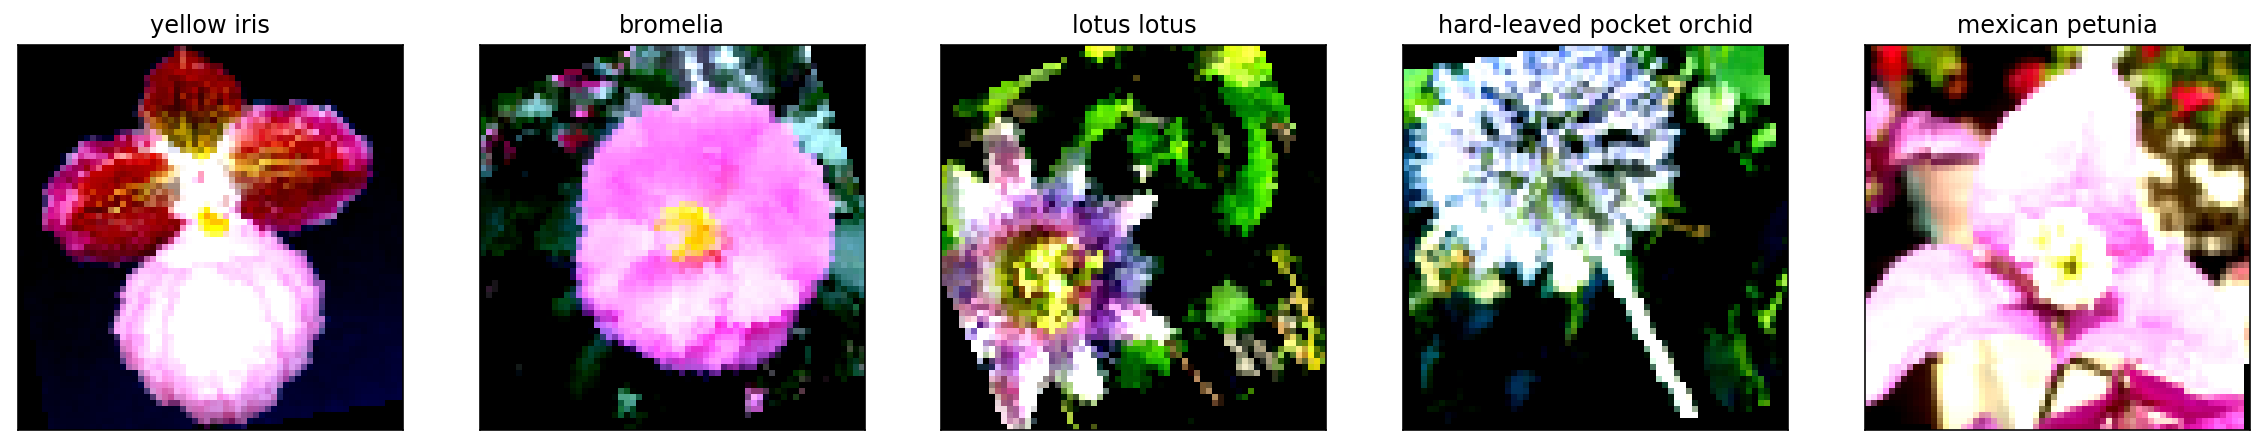

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))
# display 20 images
for idx in np.arange(5):
    
#     change tensor type to string type
#     print(labels[idx])
#     scalar_lable = int(labels[idx])
#     print(type(scalar_lable))
#     print(scalar_lable)
#     str_label = str(scalar_lable)
#     print(cat_to_name[str_label])
#     break

    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(cat_to_name[str(int(labels[idx])+1)])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [13]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [14]:
# TODO: Build and train your network
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x32x32 tensor)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # convolutional layer (sees 32x16x16 tensor)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 64x8x8 tensor)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (sees 64x4x4 tensor)        
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv14 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv15 = nn.Conv2d(512, 512, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 16 * 16 -> 500)
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(512, 102)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))        
        x = F.relu(self.conv11(x))
        x = self.pool(F.relu(self.conv12(x)))
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))       
        x = self.pool(F.relu(self.conv15(x)))
       
        # flatten image input
        x = x.view(-1, 512 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    torch.cuda.empty_cache()
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [15]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

# optimizer = optim.Adam(model.parameters(), lr=0.0001 )
optimizer = optim.Adam(model.parameters(), lr=0.0001, amsgrad=True, eps=1e-8, weight_decay=1e-5 )


In [16]:
array_train_loss = []
array_valid_loss = []
array_train_acc = []
array_valid_acc = []

In [19]:

# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    nums_train_correct = 0
    nums_valid_correct = 0
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    start = time.time()
    
    for batch_index, (data, target) in enumerate(train_loader):
#         print("-------------------train---------------------")
#         print(data.size())
#         print(target)
        
#         start_batch = time.time()

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
#         data, target = Variable(data),Variable(target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()        # (train)forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        
        _, preds = torch.max(output, 1)        
        nums_train_correct += torch.sum(preds == target.data)        
        
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
#         print('{} batch: train loss {} '.format( batch_index+1,loss.item()*data.size(0)/batch_size))

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
#         print("-------------------validate----------------------")
#         print(len(data))
#         print(target)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().type(torch.cuda.LongTensor)
            
#         data, target = Variable(data),Variable(target)

        # (validation)forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        _, preds = torch.max(output, 1)
 
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        nums_valid_correct += torch.sum(preds == target.data)

#         print('{} batch: valid loss {} '.format( batch_index+1,loss.item()*data.size(0)/batch_size))
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_acc = nums_valid_correct.double() / len(valid_loader.dataset)
    train_acc = nums_train_correct.double() / len(train_loader.dataset)

    array_train_loss.append(train_loss)
    array_valid_loss.append(valid_loss)
    array_train_acc.append(train_acc)
    array_valid_acc.append(valid_acc)
    
    
    # print training/validation statistics 
    print('Epoch: {} \tTrain Loss: {:.6f} \tVal Loss: {:.6f} \tTrain Acc: {:.2f} \tVal Acc: {:.2f}'.format(
        epoch, train_loss, valid_loss,  train_acc*100, valid_acc*100))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_flower_v6_3e'+ str(epoch) + '.pt')
        valid_loss_min = valid_loss

    print('{} epoc costs {} seconds'.format( epoch,time.time() - start))

Epoch: 1 	Train Loss: 4.525323 	Val Loss: 4.479028 	Train Acc: 2.99 	Val Acc: 1.96
Validation loss decreased (inf --> 4.479028).  Saving model ...
1 epoc costs 74.03739857673645 seconds
Epoch: 2 	Train Loss: 4.385985 	Val Loss: 4.148775 	Train Acc: 3.57 	Val Acc: 3.79
Validation loss decreased (4.479028 --> 4.148775).  Saving model ...
2 epoc costs 73.8197250366211 seconds
Epoch: 3 	Train Loss: 4.152541 	Val Loss: 4.035473 	Train Acc: 4.95 	Val Acc: 5.38
Validation loss decreased (4.148775 --> 4.035473).  Saving model ...
3 epoc costs 75.09369540214539 seconds
Epoch: 4 	Train Loss: 4.045416 	Val Loss: 3.899329 	Train Acc: 6.15 	Val Acc: 8.07
Validation loss decreased (4.035473 --> 3.899329).  Saving model ...
4 epoc costs 76.41615653038025 seconds
Epoch: 5 	Train Loss: 3.925384 	Val Loss: 3.774871 	Train Acc: 7.74 	Val Acc: 10.88
Validation loss decreased (3.899329 --> 3.774871).  Saving model ...
5 epoc costs 73.85783958435059 seconds
Epoch: 6 	Train Loss: 3.809218 	Val Loss: 3.660690

Epoch: 47 	Train Loss: 1.739452 	Val Loss: 2.004451 	Train Acc: 50.49 	Val Acc: 47.56
Validation loss decreased (2.034891 --> 2.004451).  Saving model ...
47 epoc costs 76.15528678894043 seconds
Epoch: 48 	Train Loss: 1.710142 	Val Loss: 2.005627 	Train Acc: 51.34 	Val Acc: 46.45
48 epoc costs 75.89051651954651 seconds
Epoch: 49 	Train Loss: 1.693177 	Val Loss: 1.991077 	Train Acc: 51.89 	Val Acc: 47.19
Validation loss decreased (2.004451 --> 1.991077).  Saving model ...
49 epoc costs 74.79284930229187 seconds
Epoch: 50 	Train Loss: 1.671050 	Val Loss: 1.952617 	Train Acc: 52.46 	Val Acc: 50.49
Validation loss decreased (1.991077 --> 1.952617).  Saving model ...
50 epoc costs 76.77602338790894 seconds
Epoch: 51 	Train Loss: 1.653944 	Val Loss: 1.975125 	Train Acc: 53.16 	Val Acc: 49.02
51 epoc costs 74.80555462837219 seconds
Epoch: 52 	Train Loss: 1.630060 	Val Loss: 2.017234 	Train Acc: 53.60 	Val Acc: 46.82
52 epoc costs 74.06912732124329 seconds
Epoch: 53 	Train Loss: 1.596108 	Val 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [20]:
# TODO: Save the checkpoint 

state = {'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
torch.save(state, 'model_flower_v6_3.pt')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x32x32 tensor)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # convolutional layer (sees 32x16x16 tensor)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 64x8x8 tensor)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (sees 64x4x4 tensor)        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 16 * 16 -> 500)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(512, 103)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
       
        # flatten image input
        x = x.view(-1, 32 * 4 * 4)
        # add dropout layer
#         x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)
    
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(model, filename='model_flower_v6_3.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model



In [ ]:
model = load_checkpoint(model, 'model_flower_v6_3.pt')

# move tensors to GPU if CUDA is available
if train_on_gpu:
    torch.cuda.empty_cache()
    model.cuda()

In [21]:

# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.Resize(64),
                    transforms.CenterCrop(64),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

test_image_datasets = datasets.ImageFolder(valid_dir, transform=data_transforms)

num_workers = 0
batch_size = 32

test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size, 
    num_workers=num_workers)

In [22]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()

# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    data, target = Variable(data),Variable(target)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    print("-------------------Test result----------------------")
    print(batch_idx,"--> ", correct)
        
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

-------------------Test result----------------------
0 -->  [0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0]
-------------------Test result----------------------
1 -->  [0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1]
-------------------Test result----------------------
2 -->  [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1]
-------------------Test result----------------------
3 -->  [0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1]
-------------------Test result----------------------
4 -->  [1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0]
-------------------Test result----------------------
5 -->  [0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1]
-------------------Test result----------------------
6 -->  [1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0]
-------------------Test result----------------------
7 -->  [1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0

In [23]:
for i in range(len(class_total)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            cat_to_name[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of pink primrose: 50.00% ( 4/ 8)
Test Accuracy of hard-leaved pocket orchid: 75.00% ( 3/ 4)
Test Accuracy of canterbury bells: 83.33% ( 5/ 6)
Test Accuracy of sweet pea: 40.00% ( 2/ 5)
Test Accuracy of english marigold: 66.67% ( 4/ 6)
Test Accuracy of tiger lily: 20.00% ( 2/10)
Test Accuracy of moon orchid: 20.00% ( 1/ 5)
Test Accuracy of bird of paradise: 60.00% ( 3/ 5)
Test Accuracy of monkshood: 100.00% ( 1/ 1)
Test Accuracy of globe thistle: 71.43% ( 5/ 7)
Test Accuracy of snapdragon: 0.00% ( 0/ 2)
Test Accuracy of colt's foot: 93.75% (15/16)
Test Accuracy of king protea: 36.36% ( 4/11)
Test Accuracy of spear thistle: 50.00% ( 2/ 4)
Test Accuracy of yellow iris: 83.33% ( 5/ 6)
Test Accuracy of globe-flower: 42.86% ( 3/ 7)
Test Accuracy of purple coneflower: 75.00% ( 3/ 4)
Test Accuracy of peruvian lily: 75.00% ( 6/ 8)
Test Accuracy of balloon flower: 66.67% ( 8/12)
Test Accuracy of giant white arum lily: 80.00% ( 4/ 5)
Test Accuracy of fire lily: 100.00% ( 2/ 2)
Test 

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
   
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    files = glob.glob(image_path)
    for file in files:
        im = Image.open(file)
#         print(im.size)
        width, height = im.size
        width_array.append(width)
        height_array.append(height)
    image = 
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [30]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
image = images[1]
test = nn.Conv2d(3, 1, 3) 
out = model(image)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 3, 3, 3], but got 3-dimensional input of size [3, 64, 64] instead